In [1]:
import cv2 as cv
import numpy as np
import torch
import torch.nn.functional as tnf
import kornia as kn
import scipy as sp
import matplotlib.pyplot as plt
from flowToColor import *

### 1. Optical Flow Estimation

In [2]:
def preprocess(img_loc: str) -> torch.Tensor:
    # convert given image into 0.~1. valued grayscale image
    img = cv.cvtColor(cv.imread(img_loc), cv.COLOR_BGR2GRAY)
    img_t = kn.utils.image_to_tensor(img, keepdim=False).float() / 255.
    return img_t

In [3]:
def myFlow(img_loc1: str, img_loc2: str, kernel_len: int, threshold: float) -> tuple:
    # prepare images as tensors
    img1 = preprocess(img_loc1)
    img2 = preprocess(img_loc2)
    
    # Ix, Iy tensor of img1, 1:1:H:W
    # [Ix, Iy] concat tensor of img1, 1:2:H:W
    img1_3d = img1.squeeze(0)
    deriv = torch.tensor([1, -8, 0, 8, -1]) / 12.
    deriv_g = deriv.view(1, 1, 1, -1)
    pad_x = tnf.pad(img1_3d, [2, 2], mode='replicate').unsqueeze(0)
    pad_y = tnf.pad(img1_3d.mT, [2, 2], mode='replicate').unsqueeze(0)

    Ix = tnf.conv2d(pad_x, deriv_g)
    Iy = tnf.conv2d(pad_y, deriv_g).mT
    Ix_Iy = torch.cat((Ix, Iy), dim=1)
    
    # Lucas-Kanade optical flow
    # kernel_len window collect
    h, w = img1.shape[-2:]
    p = kernel_len // 2
    pad_p = tnf.pad(Ix_Iy, [p, p, p, p], mode='replicate')
    A = torch.empty((1,2,h,w), dtype=torch.float32)
    for i in range(kernel_len):
        for j in range(kernel_len):
            A = torch.cat((A, pad_p[..., i:i+h, j:j+w]), dim=0)

    # Known tensor A of shape H:W:kernel_len^2:2
    A = torch.permute(A[1:, ...], dims=(2,3,0,1))
    # Known tensor AT of shape H:W:2:kernel_len^2
    AT = A.mT
    # Points' derivative square tensor of shape H:W:2:2
    ATA = AT @ A
    
    # It tensor between images, H:W:1:1, It = img2-img1
    img1_g = kn.filters.gaussian_blur2d(img1, kernel_size=(3, 3), sigma=(1, 1), border_type='replicate')
    img2_g = kn.filters.gaussian_blur2d(img2, kernel_size=(3, 3), sigma=(1, 1), border_type='replicate')
    It = torch.permute((img2_g - img1_g), dims=(2,3,0,1))
    
    # ATb tensor of shape H:W:2:1
    ATb = torch.sum(AT * (-It), dim=-1, keepdim=True)
    
    # Get eigen values of ATA, and determine the binary map output, H:W
    eigen_real = torch.linalg.eigvals(ATA).real
    eigen_absmin = torch.min(eigen_real.abs(), dim=-1).values
    b_map = eigen_absmin > threshold

    # Get local flow solution, H:W:2
    ATA[b_map==False, :, :] = torch.eye(2)
    sol = torch.inverse(ATA) @ ATb
    sol[b_map==False, :, :] = torch.tensor([[0.], [0.]])
    sol = sol.squeeze()
    
    # Return vx, vy flows, and bool map, H:W
    return sol[..., 0].numpy(), sol[..., 1].numpy(), b_map.numpy()

max flow: 0.6403 flow range: u = -0.620 .. 0.141; v = -0.393 .. 0.288

max flow: 3.8773 flow range: u = -1.255 .. 3.304; v = -3.381 .. 3.457



Text(0.5, 1.0, 'window size 15')

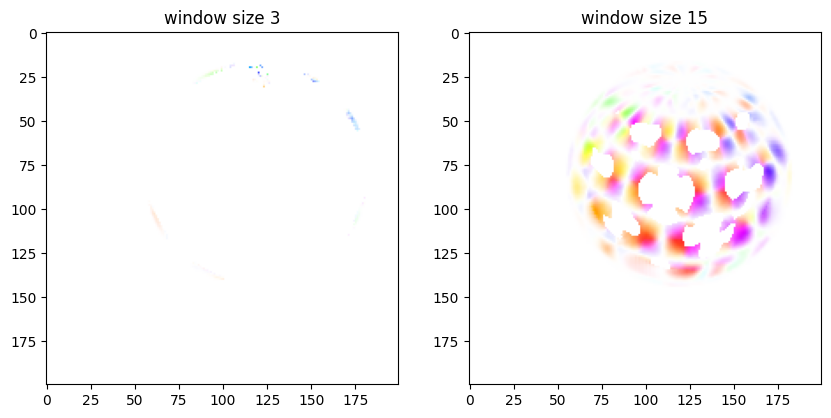

In [4]:
# The window size affects the flow sample space of each pixel. The greater window, the more likely picking up some motion
# for a pixel position. Thus showing more color in the same region.
# Sphere at window length 3 & 15
sphere_x1, sphere_y1, _ = myFlow('sphere/sphere_0.png', 'sphere/sphere_1.png', 3, 0.01)
sphere_x2, sphere_y2, _ = myFlow('sphere/sphere_0.png', 'sphere/sphere_1.png', 15, 0.01)
out_sphere1 = np.stack((sphere_x1, sphere_y1), axis=2)
out_sphere2 = np.stack((sphere_x2, sphere_y2), axis=2)

flow_res1 = flowToColor(out_sphere1, verbose=True)
flow_res2 = flowToColor(out_sphere2, verbose=True)

_, (g0, g1) = plt.subplots(1,2, figsize=(10,5))
g0.imshow(flow_res1)
g0.set_title('window size 3')
g1.imshow(flow_res2)
g1.set_title('window size 15')

max flow: 1.2064 flow range: u = -1.112 .. 0.682; v = -0.424 .. 1.206

max flow: 1.9806 flow range: u = -1.344 .. 1.169; v = -0.886 .. 1.841



Text(0.5, 1.0, 'window size 5')

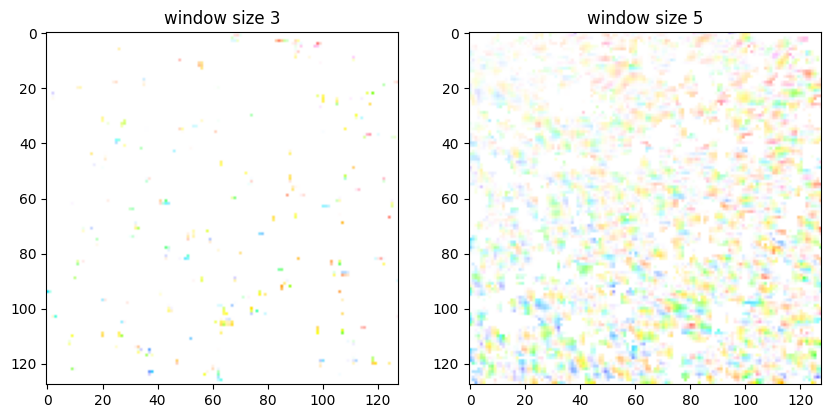

In [5]:
# Synth at window length 3 & 5
synth_x1, synth_y1, _ = myFlow('synth/synth_0.png', 'synth/synth_1.png', 3, 0.01)
synth_x2, synth_y2, _ = myFlow('synth/synth_0.png', 'synth/synth_1.png', 5, 0.01)
out_synth1 = np.stack((synth_x1, synth_y1), axis=2)
out_synth2 = np.stack((synth_x2, synth_y2), axis=2)

flow_res1 = flowToColor(out_synth1, verbose=True)
flow_res2 = flowToColor(out_synth2, verbose=True)

_, (g0, g1) = plt.subplots(1,2, figsize=(10,5))
g0.imshow(flow_res1)
g0.set_title('window size 3')
g1.imshow(flow_res2)
g1.set_title('window size 5')

max flow: 13.2043 flow range: u = -8.376 .. 11.871; v = -12.973 .. 9.882

max flow: 34.1543 flow range: u = -18.038 .. 23.738; v = -34.147 .. 29.134



Text(0.5, 1.0, 'window size 15')

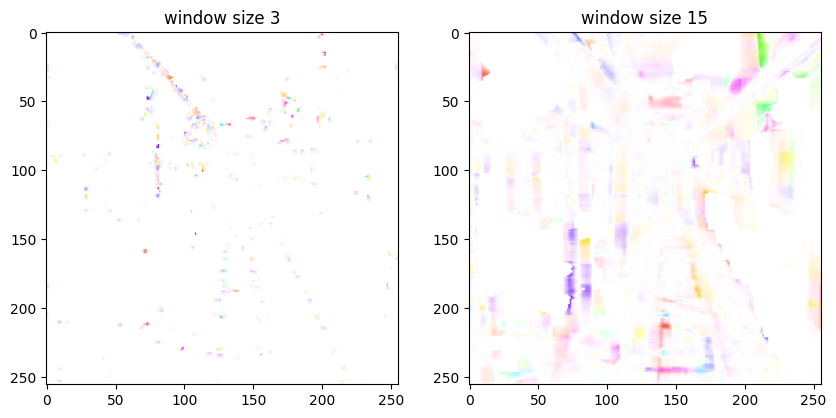

In [6]:
# Corridor at window length 3 & 15
cor_x1, cor_y1, _ = myFlow('corridor/bt_0.png', 'corridor/bt_1.png', 3, 0.01)
cor_x2, cor_y2, _ = myFlow('corridor/bt_0.png', 'corridor/bt_1.png', 15, 0.01)
out_cor1 = np.stack((cor_x1, cor_y1), axis=2)
out_cor2 = np.stack((cor_x2, cor_y2), axis=2)

flow_res1 = flowToColor(out_cor1, verbose=True)
flow_res2 = flowToColor(out_cor2, verbose=True)

_, (g0, g1) = plt.subplots(1,2, figsize=(10,5))
g0.imshow(flow_res1)
g0.set_title('window size 3')
g1.imshow(flow_res2)
g1.set_title('window size 15')

### 2. Optical Flow by Warp

In [54]:
def myWarp(img1: str, img2: str) -> tuple:
    # get x, y flow of 2 images, using window size 15, eigen 0 threshold 0.01 
    vx, vy, b_map = myFlow(img1, img2, 15, 0.01)

    # find grid-intensity interpolation function from grayscale img2
    img1_m = cv.imread(img1, flags=cv.IMREAD_GRAYSCALE).astype(np.float32) / 255.
    img2_m = cv.imread(img2, flags=cv.IMREAD_GRAYSCALE).astype(np.float32) / 255.
    h, w = img2_m.shape
    x = np.arange(0, w)
    y = np.arange(0, h)
    interp0 = sp.interpolate.RegularGridInterpolator((y, x), img2_m, method='linear', bounds_error=False)
    
    # get transitioned X, Y coordinates from img1 to img2
    xx, yy = np.meshgrid(x.astype(np.float64), y.astype(np.float64), indexing='xy')
    X = xx + vx
    Y = yy + vy
    
    # interpolate img2's intensity from shifted grid
    Z = interp0((Y, X))
    Z1 = interp0((Y, X), method='cubic')
    
    Z_filtered = np.where(b_map, Z, img1_m)
    Z1_filtered = np.where(b_map, Z1, img1_m)

    return np.abs(img1_m - Z_filtered), np.abs(img1_m - Z1_filtered)

<IPython.core.display.Javascript object>


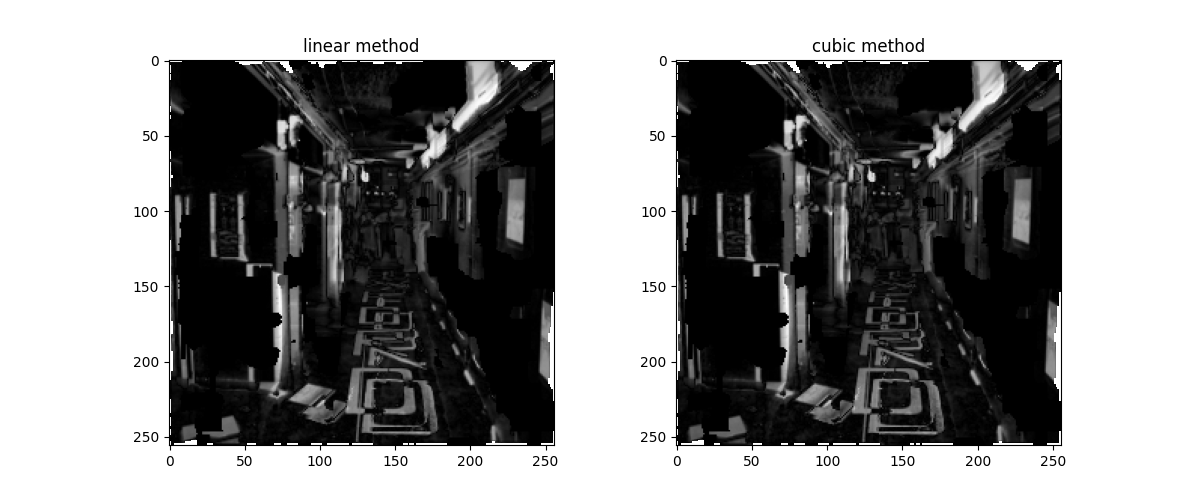

Text(0.5, 1.0, 'cubic method')

In [56]:
Z, Z1 = myWarp('corridor/bt_0.png', 'corridor/bt_1.png')

_, (g0, g1) = plt.subplots(1,2, figsize=(12,5))
g0.imshow(Z, cmap='gray')
g0.set_title('linear method')
g1.imshow(Z1, cmap='gray')
g1.set_title('cubic method')

### 3. KLT

In [9]:
# Incomplete adaptation for 20 keypoint calculation...
def myFlow2(img_loc1: str, img_loc2: str, keypoints: torch.Tensor, kernel_len: int, threshold: float) -> tuple:
    # prepare images as tensors
    img1 = preprocess(img_loc1)
    img2 = preprocess(img_loc2)

    # Ix, Iy tensor of keypoints, 1:1:H:W
    # [Ix, Iy] concat tensor of img1, 1:2:H:W
    img1_3d = img1.squeeze(0)
    deriv = torch.tensor([1, -8, 0, 8, -1]) / 12.
    deriv_g = deriv.view(1, 1, 1, -1)
    pad_x = tnf.pad(img1_3d, [2, 2], mode='replicate').unsqueeze(0)
    pad_y = tnf.pad(img1_3d.mT, [2, 2], mode='replicate').unsqueeze(0)

    Ix = tnf.conv2d(pad_x, deriv_g)
    Iy = tnf.conv2d(pad_y, deriv_g).mT
    Ix_Iy = torch.cat((Ix, Iy), dim=1)

    # Lucas-Kanade optical flow
    # kernel_len window collect
    h, w = img1.shape[-2:]
    p = kernel_len // 2
    pad_p = tnf.pad(Ix_Iy, [p, p, p, p], mode='replicate').squeeze()
    
    x = np.arange(-p, w+p)
    y = np.arange(-p, h+p)
    interp_Ix = sp.interpolate.RegularGridInterpolator((y, x), pad_p[0].numpy(), method='linear', bounds_error=False)
    interp_Iy = sp.interpolate.RegularGridInterpolator((y, x), pad_p[1].numpy(), method='linear', bounds_error=False)
    
    # get transitioned X, Y coordinates from img1 to img2
    yy, xx = keypoints[0], keypoints[1]

    # interpolate img2's intensity from shifted grid
    ix = interp_Ix((yy, xx))
    iy = interp_Iy((yy, xx))
    
    A = torch.empty((1,2,20), dtype=torch.float32)
    for i in range(kernel_len):
        for j in range(kernel_len):
            A = torch.cat((A, pad_p[..., i:i+h, j:j+w]), dim=0)

    # Known tensor A of shape H:W:kernel_len^2:2
    A = torch.permute(A[1:, ...], dims=(2,3,0,1))
    # Known tensor AT of shape H:W:2:kernel_len^2
    AT = A.mT
    # Points' derivative square tensor of shape H:W:2:2
    ATA = AT @ A
    
    # It tensor between images, H:W:1:1, It = img2-img1
    img1_g = kn.filters.gaussian_blur2d(img1, kernel_size=(3, 3), sigma=(1, 1), border_type='replicate')
    img2_g = kn.filters.gaussian_blur2d(img2, kernel_size=(3, 3), sigma=(1, 1), border_type='replicate')
    It = (img2_g - img1_g).squeeze()
    xi, yi = np.arange(0, w), np.arange(0, h)
    interp_It = sp.interpolate.RegularGridInterpolator((xi, yi), It, method='linear', bounds_error=False)
    
    # ATb tensor of shape H:W:2:1
    ATb = torch.sum(AT * (-It), dim=-1, keepdim=True)
    
    # Get eigen values of ATA, and determine the binary map output, H:W
    eigen_real = torch.linalg.eigvals(ATA).real
    eigen_absmin = torch.min(eigen_real.abs(), dim=-1).values
    b_map = eigen_absmin > threshold

    # Get local flow solution, H:W:2
    ATA[b_map==False, :, :] = torch.eye(2)
    sol = torch.inverse(ATA) @ ATb
    sol[b_map==False, :, :] = torch.tensor([[0.], [0.]])
    
    # Return [vx, vy] flows, and bool map, 20:2
    return sol.squeeze()

In [10]:
import os
# import matplotlib.animation as ma
%matplotlib notebook

# get all file names in sequence order
path = 'Hotel Sequence'
files = os.listdir(path)
files.sort(key=lambda f: len(f))
file_seq = [os.path.join(path, f) for f in files]
len(file_seq)

50

In [11]:
# get Harris corner response, select pool of ~100 points with highest responses
img0 = kn.utils.image_to_tensor(cv.imread(file_seq[0], cv.IMREAD_GRAYSCALE), keepdim=False).float() / 255
print(img0.shape)

img0_harris = kn.feature.harris_response(img0)
kp_threshold = (torch.max(img0_harris)-torch.min(img0_harris)) * 0.15
kp_map = (img0_harris > kp_threshold).squeeze()

# pool of kp coordinates, N:2, y-x
kp_pool = torch.argwhere(kp_map)
print(len(kp_pool))
kp_pool.shape

torch.Size([1, 1, 480, 512])
92


torch.Size([92, 2])

In [60]:
# select random 20 keypoings, 
choices = np.random.choice(len(kp_pool), 20, replace=True)
kps = kp_pool[sorted(choices)].float().T
kps.shape

torch.Size([2, 20])

In [13]:
lost = None
# for i, f in enumerate(file_seq[1:]):
#     xy, _ = myFlow2(file_seq[i], f, kps[i] 15, 0.01)
#     new_kp = kps[i] + xy
#     kps = torch.cat((kps, new_kp), dim=0)


<IPython.core.display.Javascript object>


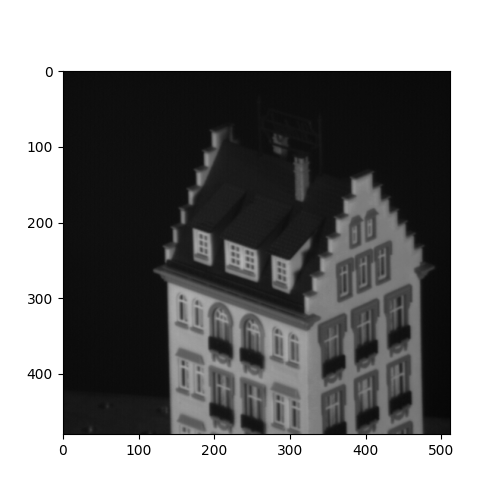

In [16]:
fig, ax = plt.subplots(figsize = (5, 5))
im = ax.imshow(cv.imread(file_seq[0]))
fig.show()
for f in file_seq[1:]:
    im.set_data(cv.imread(f))
    fig.canvas.draw()


In [15]:
# fig, ax = plt.subplots(figsize = (5, 5))
# im = ax.imshow(cv.imread(file_seq[0]))
# def animate(frame):
#     im.set_data(cv.imread(file_seq[frame]))
    
# ani = ma.FuncAnimation(fig, animate, interval=200)
# plt.show()